**This notebook analyses the contribution of MCS precipitation to total precipitation is different regions of South America**

In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

**Load in files**

In [2]:
## testing on 1 year of precip data from CPM-Hindcast ##
filename_2001 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2001.nc'
filename_2002 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2002.nc'
filename_2003 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2003.nc'
filename_2004 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2004.nc'
filename_2005 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2005.nc'
filename_2006 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2006.nc'
filename_2007 = '/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_2007.nc'


precip_2001 = xr.open_dataset(filename_2001)
precip_2001 = precip_2001.unknown

precip_2002 = xr.open_dataset(filename_2002)
precip_2002 = precip_2002.unknown

precip_2003 = xr.open_dataset(filename_2003)
precip_2003 = precip_2003.unknown

precip_2004 = xr.open_dataset(filename_2004)
precip_2004 = precip_2004.unknown

precip_2005 = xr.open_dataset(filename_2005)
precip_2005 = precip_2005.unknown

precip_2006 = xr.open_dataset(filename_2006)
precip_2006 = precip_2006.unknown

precip_2007 = xr.open_dataset(filename_2007)
precip_2007 = precip_2007.unknown


In [3]:


### for obs ###
## testing on 1 year of precip data from CPM-Hindcast ##
filename_2001 = '/scratch/hgilmour/obs/precip/precip_2001.nc'
filename_2002 = '/scratch/hgilmour/obs/precip/precip_2002.nc'
filename_2003 = '/scratch/hgilmour/obs/precip/precip_2003.nc'
filename_2004 = '/scratch/hgilmour/obs/precip/precip_2004.nc'
filename_2005 = '/scratch/hgilmour/obs/precip/precip_2005.nc'
filename_2006 = '/scratch/hgilmour/obs/precip/precip_2006.nc'
filename_2007 = '/scratch/hgilmour/obs/precip/precip_2007.nc'


precip_2001 = xr.open_dataset(filename_2001)
precip_2001 = precip_2001.precipitation_flux

precip_2002 = xr.open_dataset(filename_2002)
precip_2002 = precip_2002.precipitation_flux

precip_2003 = xr.open_dataset(filename_2003)
precip_2003 = precip_2003.precipitation_flux

precip_2004 = xr.open_dataset(filename_2004)
precip_2004 = precip_2004.precipitation_flux

precip_2005 = xr.open_dataset(filename_2005)
precip_2005 = precip_2005.precipitation_flux

precip_2006 = xr.open_dataset(filename_2006)
precip_2006 = precip_2006.precipitationCal

precip_2007 = xr.open_dataset(filename_2007)
precip_2007 = precip_2007.precipitationCal


Text(0.61, 0.72, 'NEB')

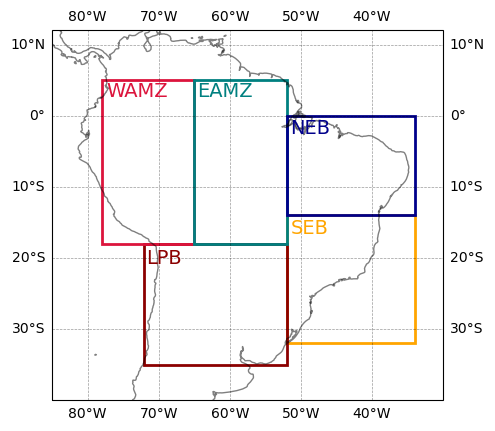

In [4]:
## split this file down into regions ##
## Create regional boxes & plot them on a map ##

import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

f=14

ax = plt.axes(projection=ccrs.PlateCarree())
#hx = m.hexbin(x_210, y_210, gridsize=(8,8),cmap='Reds',alpha=0.6,vmin=0,vmax=170)
#cbar = plt.colorbar(hx, ax=ax, shrink=0.9, pad=0.1, label='Hours with MCS present')
ax.set_extent([-85,-30,-40,12], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m',alpha=0.5)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, color='k',linestyle='--')

# ax.add_patch(mpatches.Rectangle(xy=[-70, -5], width=25, height=10, linewidth=2,
#                                 facecolor='none', edgecolor='teal',
#                                 transform=ccrs.PlateCarree()))
# ax.text(0.28, 0.83, 'NAMZ',color='teal',transform=ax.transAxes)


# ax.add_patch(mpatches.Rectangle(xy=[-70, -15], width=25, height=10, linewidth=2,
#                                 facecolor='none', edgecolor='crimson',
#                                 transform=ccrs.PlateCarree()))
# ax.text(0.28, 0.63, 'SAMZ',color='crimson',transform=ax.transAxes)


### South East Brazil (52-34^w, 32-14^S) ###
### ------------------------------------ ###
seb = ax.add_patch(mpatches.Rectangle(xy=[-52, -32], width=18, height=18, linewidth=2,
                                facecolor='none', edgecolor='orange',
                                transform=ccrs.PlateCarree()))
ax.text(0.61, 0.45, 'SEB',color='orange',transform=ax.transAxes,fontsize=f)


### East Brazil (45-35^W - 25-10^S) ###
### ------------------------------- ###
# eb = ax.add_patch(mpatches.Rectangle(xy=[-45, -25], width=10, height=17, linewidth=2,
#                                 facecolor='none', edgecolor='purple',
#                                 transform=ccrs.PlateCarree()))
# ax.text(0.74, 0.57, 'EB',color='purple',transform=ax.transAxes)


### La Plata Basin (72-52^W, 35-18^S) ###
### --------------------------------- ###
lpb = ax.add_patch(mpatches.Rectangle(xy=[-72, -35], width=20, height=17, linewidth=2,
                                facecolor='none', edgecolor='darkred',
                                transform=ccrs.PlateCarree()))
ax.text(0.24, 0.37, 'LPB',color='darkred',transform=ax.transAxes,fontsize=f)


### Western Amazon (78-65^W, 18-5^S) ###
### -------------------------------- ###
wamz = ax.add_patch(mpatches.Rectangle(xy=[-78, -18], width=13, height=23, linewidth=2,
                                facecolor='none', edgecolor='crimson',
                                transform=ccrs.PlateCarree()))
ax.text(0.14, 0.82, 'WAMZ',color='crimson',transform=ax.transAxes,fontsize=f)


### Eastern Amazon (65-52^W, 18-5^S) ###
### -------------------------------- ###
eamz = ax.add_patch(mpatches.Rectangle(xy=[-65, -18], width=13, height=23, linewidth=2,
                                facecolor='none', edgecolor='teal',
                                transform=ccrs.PlateCarree()))
ax.text(0.37, 0.82, 'EAMZ',color='teal',transform=ax.transAxes,fontsize=f)


### North East Brazil (52-34^W, 15-0^S) ###
### ----------------------------------- ###
neb = ax.add_patch(mpatches.Rectangle(xy=[-52, -14], width=18, height=14, linewidth=2,
                                facecolor='none', edgecolor='darkblue',
                                transform=ccrs.PlateCarree()))
ax.text(0.61, 0.72, 'NEB',color='darkblue',transform=ax.transAxes,fontsize=f)

#plt.savefig('regional_boxes.jpg')




**Working out lat and lons of regional boxes**

In [34]:
## taking slices of the precip_2001 dataset for each region box

eamz_precip = precip_2001.loc[dict(latitude=slice(-18, 5), longitude=slice(-65, -52))]
wamz_precip = precip_2001.loc[dict(latitude=slice(-18, 5), longitude=slice(-78, -65))]
neb_precip = precip_2001.loc[dict(latitude=slice(-14, 0), longitude=slice(-52, -34))]
seb_precip = precip_2001.loc[dict(latitude=slice(-32, -14), longitude=slice(-52, -34))]
lpb_precip = precip_2001.loc[dict(latitude=slice(-35, -18), longitude=slice(-72, -52))]


eamz_precip = eamz_precip.rename('eamz')
wamz_precip = wamz_precip.rename('wamz')
neb_precip = neb_precip.rename('neb')
seb_precip = seb_precip.rename('seb')
lpb_precip = lpb_precip.rename('lpb')

    


**Loop to calculate total precip per region per month**

In [35]:
## creating an empty dataframe to add total precip by region data to later
total_precip = pd.DataFrame(columns=['region','month','year','sum_of_precip (mm)', 'heavy_precip (mm)', 'extreme_precip (mm)'])

In [36]:
i = 0
datasets = [precip_2001, precip_2002, precip_2003, precip_2004, precip_2005, precip_2006, precip_2007]

for file in datasets:
    print(file)
    year = file[0,0,0].time.dt.year.data
    print(year)

    eamz_precip = file.loc[dict(latitude=slice(-18, 5), longitude=slice(-65, -52))]
    wamz_precip = file.loc[dict(latitude=slice(-18, 5), longitude=slice(-78, -65))]
    neb_precip = file.loc[dict(latitude=slice(-14, 0), longitude=slice(-52, -34))]
    seb_precip = file.loc[dict(latitude=slice(-32, -14), longitude=slice(-52, -34))]
    lpb_precip = file.loc[dict(latitude=slice(-35, -18), longitude=slice(-72, -52))]
    # if year == 2006:
    #     eamz_precip = file.loc[dict(lat=slice(-18, 5), lon=slice(-65, -52))]
    #     wamz_precip = file.loc[dict(lat=slice(-18, 5), lon=slice(-78, -65))]
    #     neb_precip = file.loc[dict(lat=slice(-14, 0), lon=slice(-52, -34))]
    #     seb_precip = file.loc[dict(lat=slice(-32, -14), lon=slice(-52, -34))]
    #     lpb_precip = file.loc[dict(lat=slice(-35, -18), lon=slice(-72, -52))]
    
    # elif year == 2007:
    #     eamz_precip = file.loc[dict(lat=slice(-18, 5), lon=slice(-65, -52))]
    #     wamz_precip = file.loc[dict(lat=slice(-18, 5), lon=slice(-78, -65))]
    #     neb_precip = file.loc[dict(lat=slice(-14, 0), lon=slice(-52, -34))]
    #     seb_precip = file.loc[dict(lat=slice(-32, -14), lon=slice(-52, -34))]
    #     lpb_precip = file.loc[dict(lat=slice(-35, -18), lon=slice(-72, -52))]        
    
    # else:
    #     eamz_precip = file.loc[dict(latitude=slice(-18, 5), longitude=slice(-65, -52))]
    #     wamz_precip = file.loc[dict(latitude=slice(-18, 5), longitude=slice(-78, -65))]
    #     neb_precip = file.loc[dict(latitude=slice(-14, 0), longitude=slice(-52, -34))]
    #     seb_precip = file.loc[dict(latitude=slice(-32, -14), longitude=slice(-52, -34))]
    #     lpb_precip = file.loc[dict(latitude=slice(-35, -18), longitude=slice(-72, -52))]


    eamz_precip = eamz_precip.rename('eamz')
    wamz_precip = wamz_precip.rename('wamz')
    neb_precip = neb_precip.rename('neb')
    seb_precip = seb_precip.rename('seb')
    lpb_precip = lpb_precip.rename('lpb')

    dataarrays = [eamz_precip, wamz_precip, neb_precip, seb_precip, lpb_precip]

    for array in dataarrays:
        print(array)
        region = array.name
        for month in np.unique(array.time.dt.month):
            month = month
            subset = array[array.time.dt.month == month]
            year = year
            precip = subset.data.sum()*3600
            precip_extreme = subset.data[subset.data>=0.0139].sum()*3600 # 0.0139 is the equivalent to 50 mm hr-1 in kg m-2 s-1
            precip_heavy = subset.data[subset.data>=0.0028].sum()*3600 # 0.0028 is the equivalent to 10 mm hr-1 in kg m-2 s-1

            total_precip.loc[i] = [region, month, year, precip, precip_heavy, precip_extreme]
            i = i+1
    print('Finished for year: ', year)

<xarray.DataArray 'unknown' (time: 8760, latitude: 550, longitude: 600)>
[2890800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01T00:30:00 ... 2001-12-31T23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Attributes:
    units:         kg m-2 s-1
    grid_mapping:  latitude_longitude
2001
<xarray.DataArray 'eamz' (time: 8760, latitude: 230, longitude: 130)>
[261924000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01T00:30:00 ... 2001-12-31T23:30:00
  * latitude   (latitude) float64 -17.95 -17.85 -17.75 -17.65 ... 4.75 4.85 4.95
  * longitude  (longitude) float64 -64.95 -64.85 -64.75 ... -52.25 -52.15 -52.05
Attributes:
    units:         kg m-2 s-1
    grid_mapping:  latitude_longitude
<xarray.DataArray 'wamz' (time: 8760, latitude: 230, longitude: 130)>
[261924000 values with dtype=float32]

In [37]:
total_precip

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm)
0,eamz,1,2001,1947.772095,4.002533e+06,378041.363525
1,eamz,2,2001,1702.529663,3.590319e+06,345229.403687
2,eamz,3,2001,1745.361816,3.822489e+06,409440.618896
3,eamz,4,2001,1328.225342,2.846759e+06,286877.581787
4,eamz,5,2001,1105.727539,2.416102e+06,233168.087769
...,...,...,...,...,...,...
415,lpb,8,2007,85.798203,1.079742e+02,0.000000
416,lpb,9,2007,209.383636,5.984580e+04,0.000000
417,lpb,10,2007,631.307800,6.328818e+05,20172.771263
418,lpb,11,2007,642.612793,9.858555e+05,59836.116028


In [38]:
total_precip.to_hdf('/project/cssp_brazil/mcs_tracking_HG/analysis/total_rainfall_by_region/cpm_hindcast.hdf', 'table')

**START FROM HERE NOW THAT THE TOTAL REGION RAINFALL DATAFRAMES HAVE BEEN CREATED...**

In [2]:
obs_file = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/analysis/total_rainfall_by_region/satellite_obs.hdf', 'table')
cpm_file = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/analysis/total_rainfall_by_region/cpm_hindcast.hdf', 'table')


In [3]:
type = ['GPM-IMERG'] * obs_file.shape[0] # adding a new column called 'type' ready for when the obs and cpm dataframes are combined to 1 to help with differentiating them

obs_file['type'] = type

obs_file

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm),type
0,eamz,1,2001,8.961834e+06,1.777290e+06,33442.812500,GPM-IMERG
1,eamz,2,2001,6.503194e+06,1.081699e+06,20748.798828,GPM-IMERG
2,eamz,3,2001,6.995929e+06,1.256366e+06,33688.562500,GPM-IMERG
3,eamz,4,2001,5.610566e+06,1.014347e+06,41627.265625,GPM-IMERG
4,eamz,5,2001,5.485962e+06,1.044445e+06,36410.445312,GPM-IMERG
...,...,...,...,...,...,...,...
415,lpb,8,2007,7.922114e+05,9.303177e+04,689.989990,GPM-IMERG
416,lpb,9,2007,1.456312e+06,1.544074e+05,0.000000,GPM-IMERG
417,lpb,10,2007,2.926988e+06,4.639582e+05,0.000000,GPM-IMERG
418,lpb,11,2007,2.583257e+06,5.708591e+05,2852.005615,GPM-IMERG


In [4]:
type = ['CPM-Hindcast'] * cpm_file.shape[0]
cpm_file['type'] = type
cpm_file['sum_of_precip (mm)'] = cpm_file['sum_of_precip (mm)']*3600

cpm_file

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm),type
0,eamz,1,2001,7.011980e+06,4.002533e+06,378041.363525,CPM-Hindcast
1,eamz,2,2001,6.129107e+06,3.590319e+06,345229.403687,CPM-Hindcast
2,eamz,3,2001,6.283302e+06,3.822489e+06,409440.618896,CPM-Hindcast
3,eamz,4,2001,4.781611e+06,2.846759e+06,286877.581787,CPM-Hindcast
4,eamz,5,2001,3.980619e+06,2.416102e+06,233168.087769,CPM-Hindcast
...,...,...,...,...,...,...,...
415,lpb,8,2007,3.088735e+05,1.079742e+02,0.000000,CPM-Hindcast
416,lpb,9,2007,7.537811e+05,5.984580e+04,0.000000,CPM-Hindcast
417,lpb,10,2007,2.272708e+06,6.328818e+05,20172.771263,CPM-Hindcast
418,lpb,11,2007,2.313406e+06,9.858555e+05,59836.116028,CPM-Hindcast


In [5]:
## In GPM_IMERG, the sum_of_precip (mm) for wamz in 05 2001 is 10^38 (much too high so something weird is going on with the data). Therefore, this month of wamz data needs to be removed from the dataframe before plotting... ##

# create a Boolean mask for the rows to remove
mask = obs_file['sum_of_precip (mm)'] > 10000000

obs_file = obs_file[~mask]

# print the resulting DataFrame
print(obs_file)


    region  month  year  sum_of_precip (mm)  heavy_precip (mm)  \
0     eamz      1  2001        8.961834e+06       1.777290e+06   
1     eamz      2  2001        6.503194e+06       1.081699e+06   
2     eamz      3  2001        6.995929e+06       1.256366e+06   
3     eamz      4  2001        5.610566e+06       1.014347e+06   
4     eamz      5  2001        5.485962e+06       1.044445e+06   
..     ...    ...   ...                 ...                ...   
415    lpb      8  2007        7.922114e+05       9.303177e+04   
416    lpb      9  2007        1.456312e+06       1.544074e+05   
417    lpb     10  2007        2.926988e+06       4.639582e+05   
418    lpb     11  2007        2.583257e+06       5.708591e+05   
419    lpb     12  2007        3.578524e+06       6.349104e+05   

     extreme_precip (mm)       type  
0           33442.812500  GPM-IMERG  
1           20748.798828  GPM-IMERG  
2           33688.562500  GPM-IMERG  
3           41627.265625  GPM-IMERG  
4           36410

In [6]:
## Join the 2 separate dataframes together (obs and cpm to make it easier to plot) ##
combined = cpm_file.append(obs_file)

Text(-7.5, 11000000, 'Mean monthly accumulated precipitation per region per month')

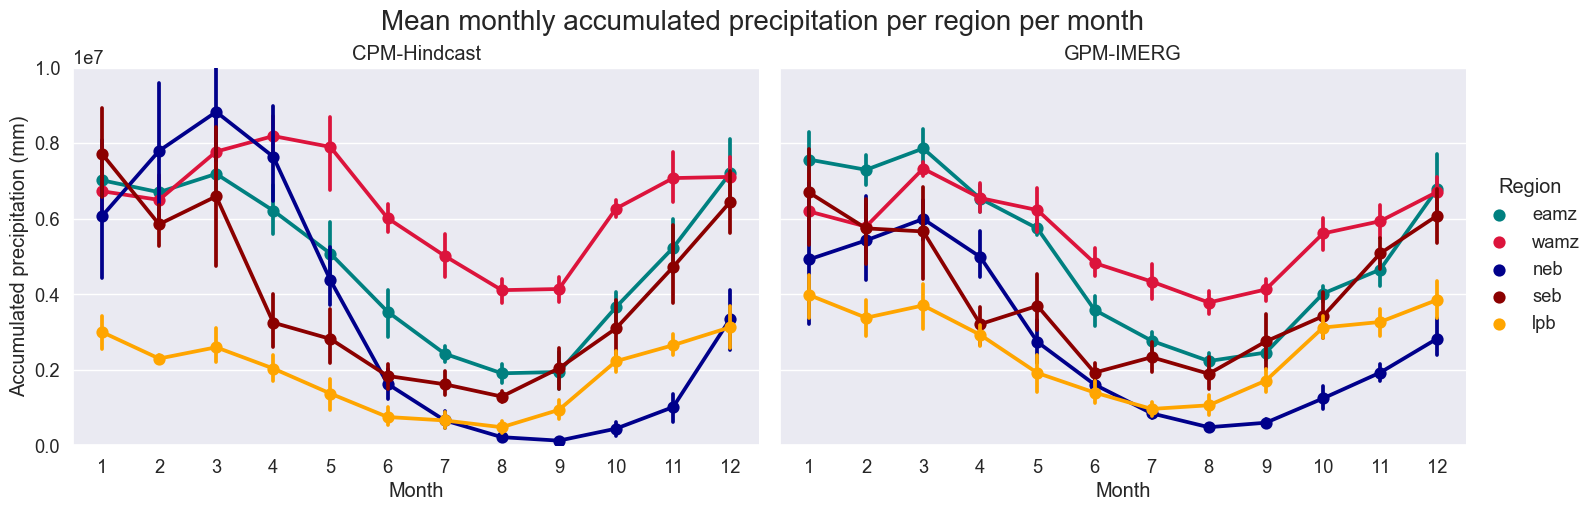

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.set(rc={'figure.figsize':(11.7,11.27)})
sns.set(font_scale=1.2)

g = sns.catplot(x="month", y="sum_of_precip (mm)", hue="region", data=combined, col='type',
    palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], kind='point', aspect=1.5, facet_kws=dict(sharex=False)
)
g.set_axis_labels("Month", "Accumulated precipitation (mm)")
g.legend.set_title("Region")
g.set_titles("{col_name}")
plt.ylim(0,10000000)
plt.text(-7.5,11000000,'Mean monthly accumulated precipitation per region per month', fontsize=20)

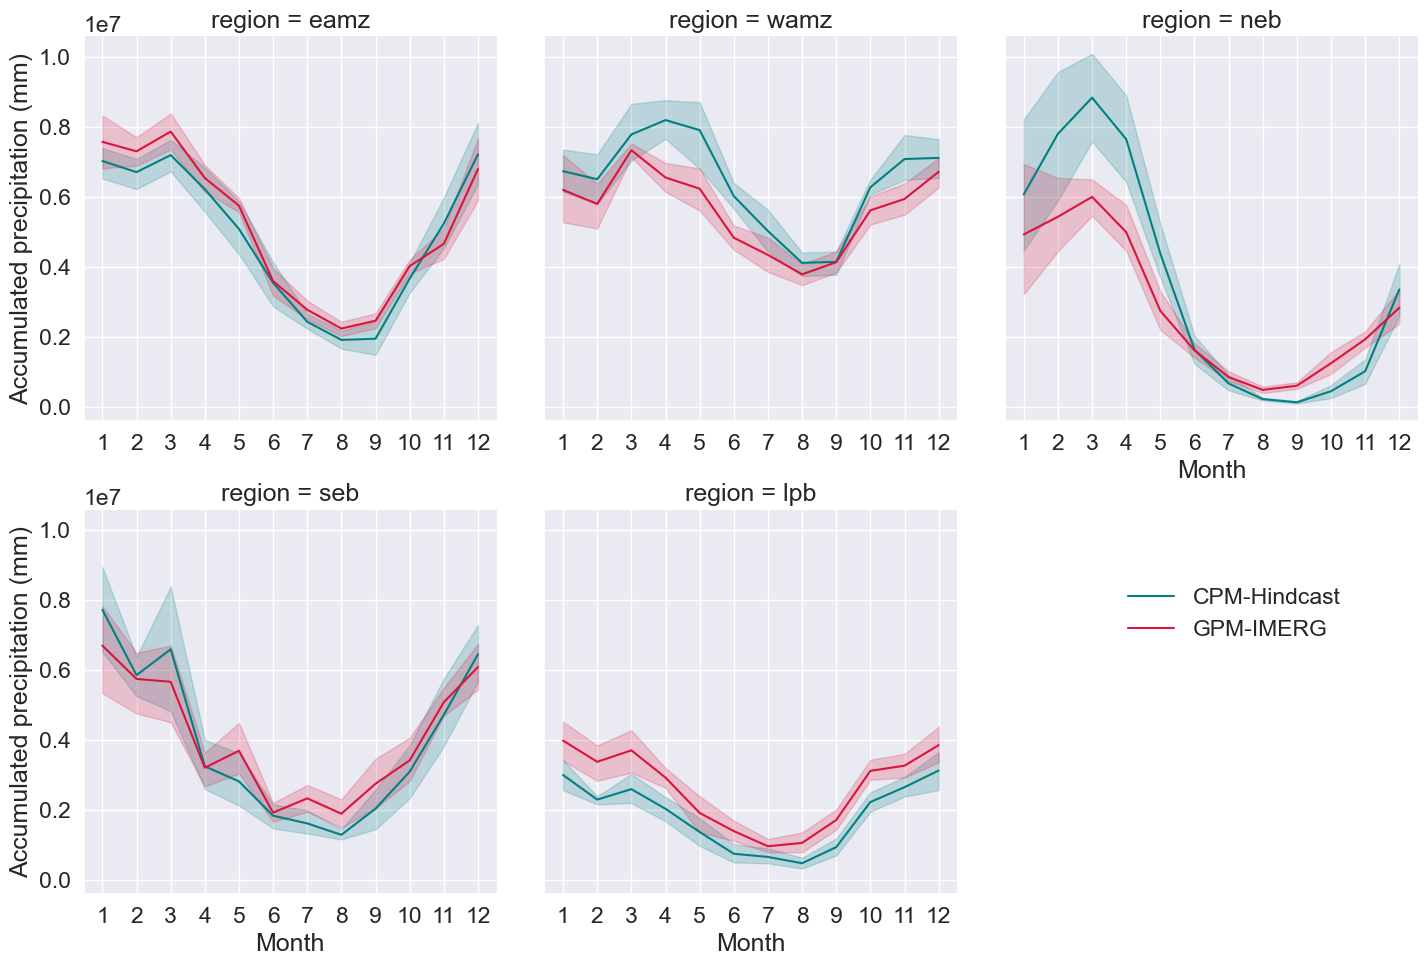

In [8]:
sns.set_theme(style="whitegrid")
#sns.set(rc={'figure.figsize':(11.7,11.27)})
sns.set(font_scale=1.5)

g = sns.relplot(
    data=combined, x="month", y="sum_of_precip (mm)", hue='type',
    col="region",
    kind="line", col_wrap=3, palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], facet_kws=dict(sharex=False)
)

g.set_axis_labels("Month", "Accumulated precipitation (mm)")
g.legend.set_title(" ")
g.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45))
g.set(xticks=np.arange(1,13,1))
g.set_xticklabels(labels=np.arange(1,13), step=1)

**Loop to calculate total accumulated *EXTREME* precipitation per region per month**

Text(-10, 850000, 'Mean monthly accumulated extreme precipitation (>=50mm/hr) per region per month')

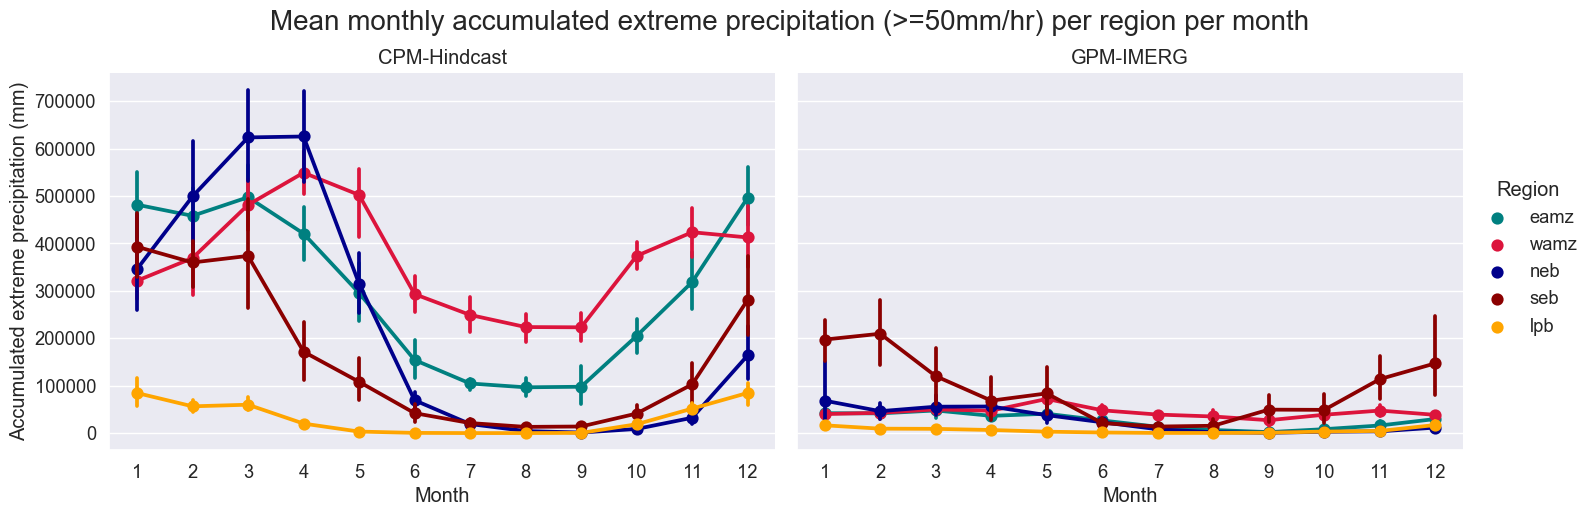

In [9]:

sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.catplot(x="month", y="extreme_precip (mm)", hue="region", data=combined, col='type',
    palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], kind='point', aspect=1.5, facet_kws=dict(sharex=False)
)
g.set_axis_labels("Month", "Accumulated extreme precipitation (mm)")
g.legend.set_title("Region")
g.set_titles("{col_name}")
#plt.ylim(0,700000)
plt.text(-10,850000,'Mean monthly accumulated extreme precipitation (>=50mm/hr) per region per month', fontsize=20)

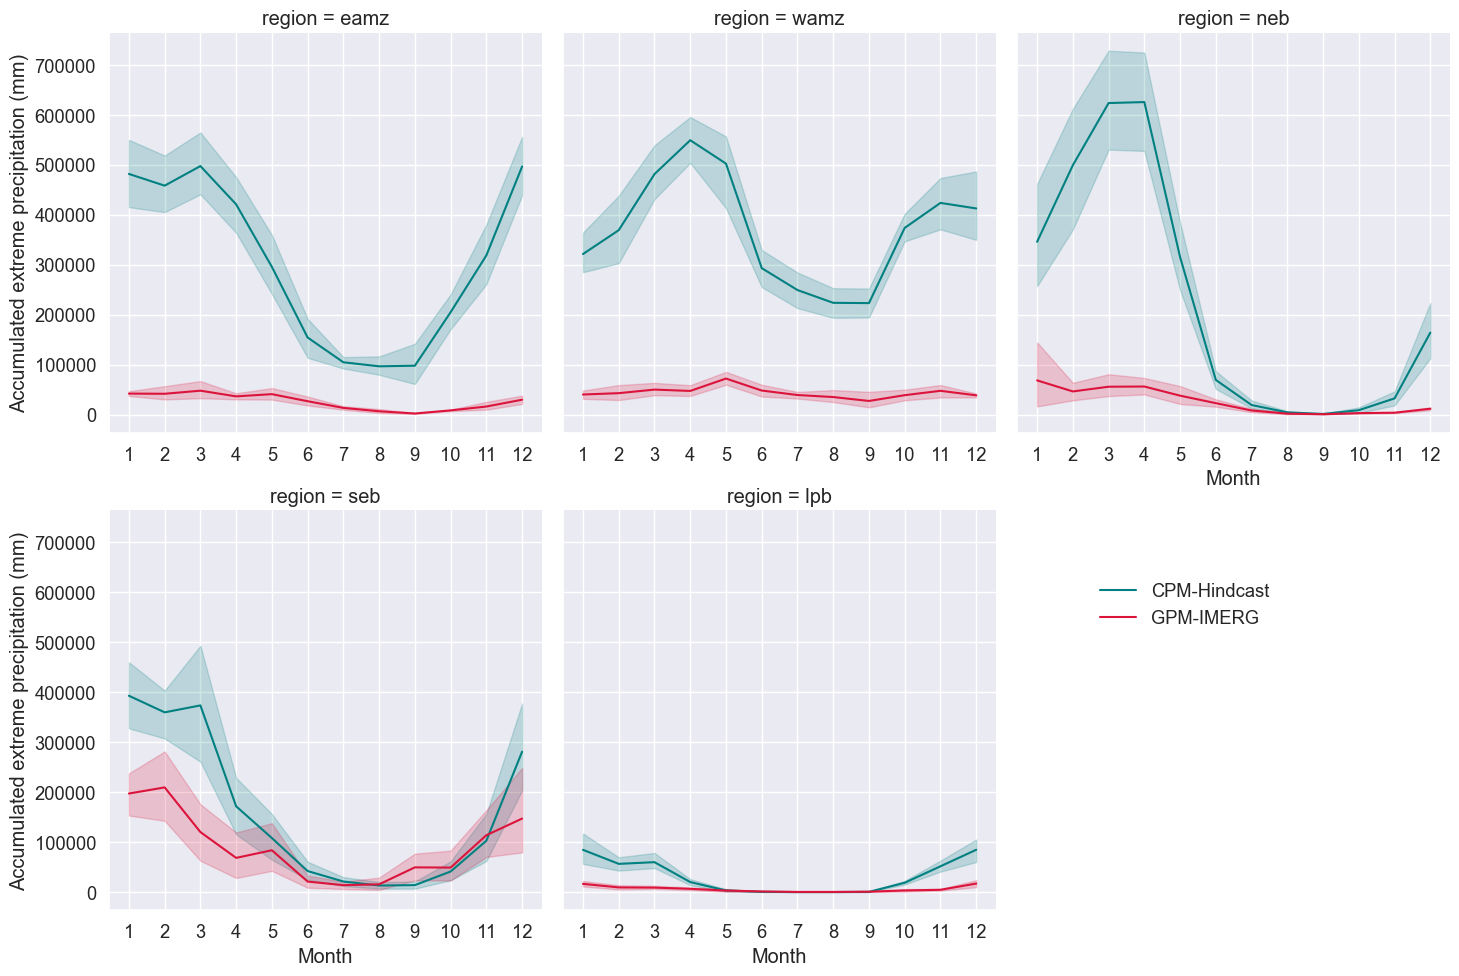

In [10]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.relplot(
    data=combined, x="month", y="extreme_precip (mm)", hue='type',
    col="region",
    kind="line", col_wrap=3, palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], facet_kws=dict(sharex=False)
)

g.set_axis_labels("Month", "Accumulated extreme precipitation (mm)")
g.legend.set_title(" ")
g.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45))
g.set(xticks=np.arange(1,13,1))
g.set_xticklabels(labels=np.arange(1,13), step=1)

**Plots for the total accumulation of *HEAVY* rainfall in each region per month**

Text(-10, 7500000, 'Mean monthly accumulated extreme precipitation (>=10mm/hr) per region per month')

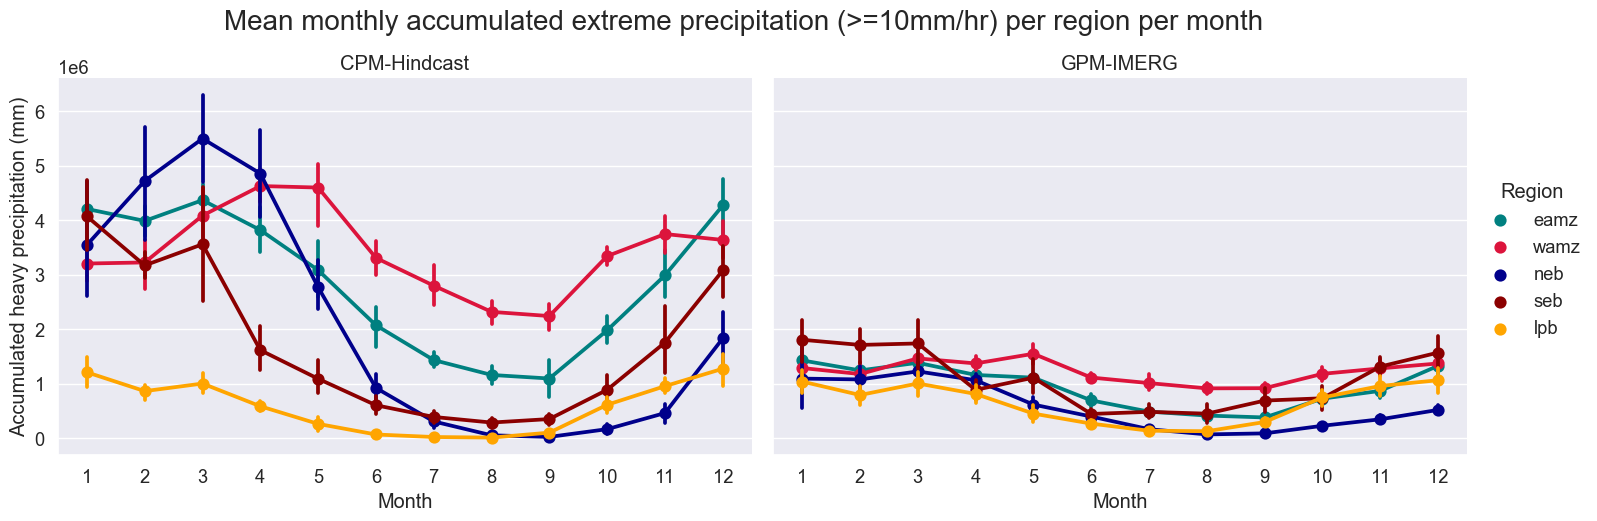

In [11]:

sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.catplot(x="month", y="heavy_precip (mm)", hue="region", data=combined, col='type',
    palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], kind='point', aspect=1.5, facet_kws=dict(sharex=False)
)
g.set_axis_labels("Month", "Accumulated heavy precipitation (mm)")
g.legend.set_title("Region")
g.set_titles("{col_name}")
#plt.ylim(0,700000)
plt.text(-10,7500000,'Mean monthly accumulated extreme precipitation (>=10mm/hr) per region per month', fontsize=20)

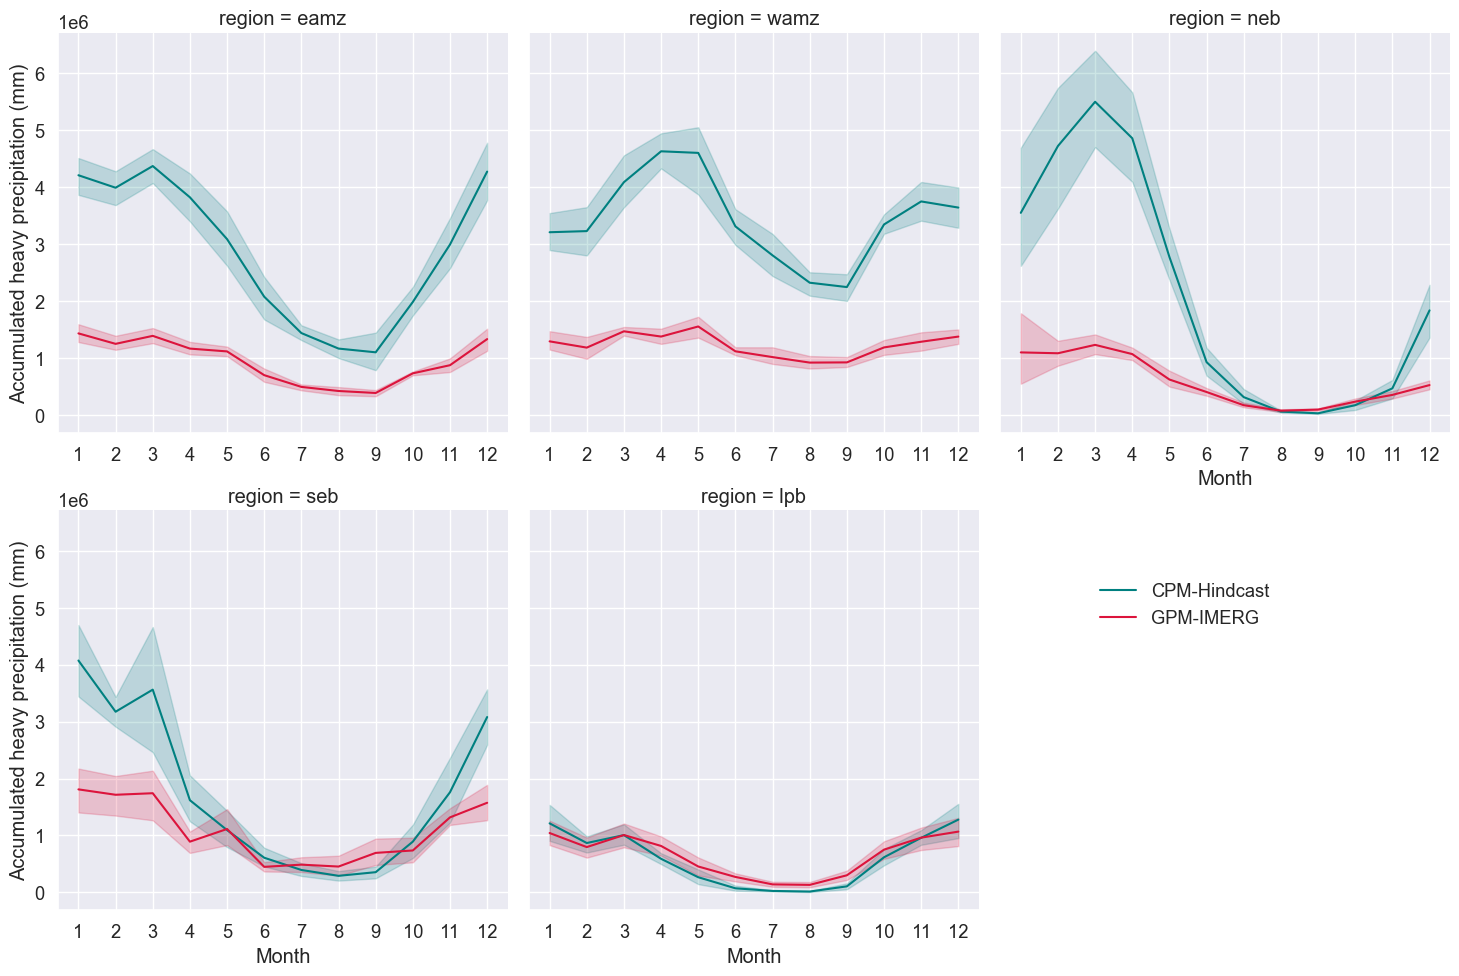

In [12]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.relplot(
    data=combined, x="month", y="heavy_precip (mm)", hue='type',
    col="region",
    kind="line", col_wrap=3, palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], facet_kws=dict(sharex=False)
)

g.set_axis_labels("Month", "Accumulated heavy precipitation (mm)")
g.legend.set_title(" ")
g.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45))
g.set(xticks=np.arange(1,13,1))
g.set_xticklabels(labels=np.arange(1,13), step=1)

**Calculating proportion of total precip in each region that comes from MCSs**

In [13]:
## 1) Load in the regions tracks (e.g. '/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/eamz_tracks_cpm.hdf')

## 2) Check that there is only years 2001-2007 in these files

## 3) For each region, sum the total_precip for each month

## 4)Create a new column in the dataframe for 'MCS contribution' and add the total_precip value to each month

## 5) Create a new column in the dataframe for 'MCS contribution as % of total" and calculate the % of the total that the MCS contribution is

## 6) Repeat for other regions

In [14]:
eamz_tracks_cpm = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/eamz_tracks_cpm.hdf', 'table')
wamz_tracks_cpm = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/wamz_tracks_cpm.hdf', 'table')
neb_tracks_cpm =pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/neb_tracks_cpm.hdf', 'table')
seb_tracks_cpm =pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/seb_tracks_cpm.hdf', 'table')
lpb_tracks_cpm =pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/lpb_tracks_cpm.hdf', 'table')

In [15]:
eamz_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/eamz_tracks_obs.hdf', 'table')
wamz_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/wamz_tracks_obs.hdf', 'table')
neb_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/neb_tracks_obs.hdf', 'table')
seb_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/seb_tracks_obs.hdf', 'table')
lpb_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/lpb_tracks_obs.hdf', 'table')

In [20]:
cpm_file

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm),type
0,eamz,1,2001,7.011980e+06,4.002533e+06,378041.363525,CPM-Hindcast
1,eamz,2,2001,6.129107e+06,3.590319e+06,345229.403687,CPM-Hindcast
2,eamz,3,2001,6.283302e+06,3.822489e+06,409440.618896,CPM-Hindcast
3,eamz,4,2001,4.781611e+06,2.846759e+06,286877.581787,CPM-Hindcast
4,eamz,5,2001,3.980619e+06,2.416102e+06,233168.087769,CPM-Hindcast
...,...,...,...,...,...,...,...
415,lpb,8,2007,3.088735e+05,1.079742e+02,0.000000,CPM-Hindcast
416,lpb,9,2007,7.537811e+05,5.984580e+04,0.000000,CPM-Hindcast
417,lpb,10,2007,2.272708e+06,6.328818e+05,20172.771263,CPM-Hindcast
418,lpb,11,2007,2.313406e+06,9.858555e+05,59836.116028,CPM-Hindcast


In [21]:
cpm_file['mcs_total_precip'] = np.zeros(420)
cpm_file['mcs_heavy_precip'] = np.zeros(420)
cpm_file['mcs_extreme_precip'] = np.zeros(420)

In [22]:
cpm_file

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm),type,mcs_total_precip,mcs_heavy_precip,mcs_extreme_precip
0,eamz,1,2001,7.011980e+06,4.002533e+06,378041.363525,CPM-Hindcast,0.0,0.0,0.0
1,eamz,2,2001,6.129107e+06,3.590319e+06,345229.403687,CPM-Hindcast,0.0,0.0,0.0
2,eamz,3,2001,6.283302e+06,3.822489e+06,409440.618896,CPM-Hindcast,0.0,0.0,0.0
3,eamz,4,2001,4.781611e+06,2.846759e+06,286877.581787,CPM-Hindcast,0.0,0.0,0.0
4,eamz,5,2001,3.980619e+06,2.416102e+06,233168.087769,CPM-Hindcast,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
415,lpb,8,2007,3.088735e+05,1.079742e+02,0.000000,CPM-Hindcast,0.0,0.0,0.0
416,lpb,9,2007,7.537811e+05,5.984580e+04,0.000000,CPM-Hindcast,0.0,0.0,0.0
417,lpb,10,2007,2.272708e+06,6.328818e+05,20172.771263,CPM-Hindcast,0.0,0.0,0.0
418,lpb,11,2007,2.313406e+06,9.858555e+05,59836.116028,CPM-Hindcast,0.0,0.0,0.0


In [26]:
dataframes = [eamz_tracks_cpm, wamz_tracks_cpm, neb_tracks_cpm, seb_tracks_cpm, lpb_tracks_cpm]
#i = 0

eamz_tracks_cpm.name = 'eamz'
wamz_tracks_cpm.name = 'wamz'
neb_tracks_cpm.name = 'neb'
seb_tracks_cpm.name = 'seb'
lpb_tracks_cpm.name = 'lpb'

for dataframe in dataframes:
    region = dataframe.name
    print(region)
    for year in np.unique(dataframe.datetime.dt.year):
        print(year)
        subset = dataframe[dataframe.datetime.dt.year == year]
        for month in np.unique(subset.datetime.dt.month):
            print(month)
            subset1 = subset[subset.datetime.dt.month == month]
            precip_total = subset1.total_precip.sum()
            print(precip_total)
            precip_extreme = subset1.extreme_precip.sum()
            precip_heavy = subset1.heavy_precip.sum()

            cpm_file['mcs_total_precip'][(cpm_file.year == year) & (cpm_file.month == month) & (cpm_file.region == region)] = precip_total
            cpm_file['mcs_heavy_precip'][(cpm_file.year == year) & (cpm_file.month == month) & (cpm_file.region == region)] = precip_heavy
            cpm_file['mcs_extreme_precip'][(cpm_file.year == year) & (cpm_file.month == month) & (cpm_file.region == region)] = precip_extreme

            # cpm_file.mcs_total_precip.loc[i] = precip_total
            # cpm_file.mcs_heavy_precip.loc[i] = precip_heavy
            # cpm_file.mcs_extreme_precip.loc[i] = precip_extreme
            #i = i+1
        print('Finished for year: ', year)
    print('finished for dataframe')

eamz
2001
1
1498386.1121618808
2
1412427.1229777846
3
1550344.6729813516
4
1210268.9142618375
5
1214073.7725387625
6
1664471.6677765758
7
426675.2967231083
8
722585.2665698344
9
673393.8142735981
10
1723696.8139455593
11
1244902.6423035017
12
1677291.1353784814
Finished for year:  2001
2002
1
2047322.6637036894
2
1588230.4940530383
3
1716535.681029455
4
1137735.0034161687
5
1026768.2068513269
6
1408636.4326541298
7
1014587.8858622494
8
568934.1744636025
9
992921.369851625
10
1338995.8310411836
11
1830539.2211833908
12
2309770.3736386215
Finished for year:  2002
2003
1
1752571.3881608034
2
1353846.123713065
3
1735486.925867469
4
1240411.7133277508
5
1194500.6011378388
6
736189.8834166249
7
350450.63587727695
8
824636.507121343
9
619365.0040678042
10
1281545.322135679
11
1589045.1653191443
12
1404349.7078910496
Finished for year:  2003
2004
1
2085560.8221283383
2
1842962.4496234746
3
2334266.342705569
4
1863299.2502190303
5
1700720.8050188047
6
840162.3613314264
7
750275.4186412352
8
892

In [83]:
cpm_file['mcs_contribution']=(cpm_file.mcs_total_precip / cpm_file['sum_of_precip (mm)'])*100
cpm_file['mcs_heavy_contribution']=(cpm_file.mcs_heavy_precip / cpm_file['heavy_precip (mm)'])*100
cpm_file['mcs_extreme_contribution']=(cpm_file.mcs_extreme_precip / cpm_file['extreme_precip (mm)'])*100

In [61]:
cpm_file.mcs_contribution[(cpm_file.region == 'seb') & (cpm_file.month == 10)].max()

29.08150075451929

In [62]:
## NOT SURE WHAT IS GOING ON WITH THESE 3 --- POSSIBLY CHECK THE BOUNDING BOX FOR LPB TO MAKE SURE ITS THE SAME AS THE ONE USED FOR THE REGIONAL MCS ANALYSIS ##

cpm_file[cpm_file.mcs_contribution > 100]

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm),type,mcs_total_precip,mcs_heavy_precip,mcs_extreme_precip,mcs_contribution
115,lpb,8,2002,6.468932e+05,28160.595703,112.211864,CPM-Hindcast,6.657592e+05,118810.882754,1497.400192,102.916388
116,lpb,9,2002,1.372571e+06,211887.281799,52.630289,CPM-Hindcast,2.413915e+06,357880.915324,0.000000,175.868055
355,lpb,8,2006,4.508961e+05,9362.397766,0.000000,CPM-Hindcast,6.338562e+05,98942.345688,103.718399,140.576998


**Now the same for observations**

In [56]:
obs_file['mcs_total_precip'] = np.zeros(416)
obs_file['mcs_heavy_precip'] = np.zeros(416)
obs_file['mcs_extreme_precip'] = np.zeros(416)

In [57]:
dataframes = [eamz_tracks_obs, wamz_tracks_obs, neb_tracks_obs, seb_tracks_obs, lpb_tracks_obs]
#i = 0

eamz_tracks_obs.name = 'eamz'
wamz_tracks_obs.name = 'wamz'
neb_tracks_obs.name = 'neb'
seb_tracks_obs.name = 'seb'
lpb_tracks_obs.name = 'lpb'

for dataframe in dataframes:
    region = dataframe.name
    print(region)
    for year in np.unique(dataframe.datetime.dt.year):
        print(year)
        subset = dataframe[dataframe.datetime.dt.year == year]
        for month in np.unique(subset.datetime.dt.month):
            print(month)
            subset1 = subset[subset.datetime.dt.month == month]
            precip_total = subset1.total_precip.sum()
            print(precip_total)
            precip_extreme = subset1.extreme_precip.sum()
            precip_heavy = subset1.heavy_precip.sum()

            obs_file['mcs_total_precip'][(obs_file.year == year) & (obs_file.month == month) & (obs_file.region == region)] = precip_total
            obs_file['mcs_heavy_precip'][(obs_file.year == year) & (obs_file.month == month) & (obs_file.region == region)] = precip_heavy
            obs_file['mcs_extreme_precip'][(obs_file.year == year) & (obs_file.month == month) & (obs_file.region == region)] = precip_extreme

            # cpm_file.mcs_total_precip.loc[i] = precip_total
            # cpm_file.mcs_heavy_precip.loc[i] = precip_heavy
            # cpm_file.mcs_extreme_precip.loc[i] = precip_extreme
            #i = i+1
        print('Finished for year: ', year)
    print('finished for dataframe')

eamz
2001
1
2249452.1119152186
2
832519.1003121734
3
995273.9560319111
4
801272.9943476319
5
1509863.2052595336
6
794528.2281799316
7
585695.1148706377
8
272242.5368140936
9
501179.2816581726
10
721531.026691556
11
899104.8166864477
12
1936404.0117122233
Finished for year:  2001
2002
1
1176774.7808280485
2
931122.3020966053
3
1198806.806065064
4
1451351.3575783134
5
1641293.9948771112
6
649854.436886549
7
580084.3269732222
8
479055.1618614197
9
466638.11219124123
10
680194.0233480353
11
841484.6270121317
12
1605475.637405336
Finished for year:  2002
2003
1
1425404.61209625
2
1156029.2688557925
3
1233980.3160461076
4
826903.5763646737
5
1690876.3952745646
6
920641.1328192204
7
524811.5147253722
8
412074.4607582092
9
341487.0133028254
10
1117442.1656428576
11
1036251.3975077122
12
731514.8361141719
Finished for year:  2003
2004
1
1721325.8280415088
2
934563.4910561731
3
1457450.6919088417
4
1085220.7311902046
5
1475772.90965751
6
627700.9819815755
7
418002.0262040794
8
229192.54651641846

In [58]:
obs_file

,region,month,year,sum_of_precip (mm),heavy_precip (mm),extreme_precip (mm),type,mcs_total_precip,mcs_heavy_precip,mcs_extreme_precip
0,eamz,1,2001,8.961834e+06,1.777290e+06,33442.812500,GPM-IMERG,2.249452e+06,683036.474339,15252.713173
1,eamz,2,2001,6.503194e+06,1.081699e+06,20748.798828,GPM-IMERG,8.325191e+05,237936.194158,2645.754776
2,eamz,3,2001,6.995929e+06,1.256366e+06,33688.562500,GPM-IMERG,9.952740e+05,260479.689203,5805.146667
3,eamz,4,2001,5.610566e+06,1.014347e+06,41627.265625,GPM-IMERG,8.012730e+05,216338.480833,7248.215652
4,eamz,5,2001,5.485962e+06,1.044445e+06,36410.445312,GPM-IMERG,1.509863e+06,451130.758551,21343.858932
...,...,...,...,...,...,...,...,...,...,...
415,lpb,8,2007,7.922114e+05,9.303177e+04,689.989990,GPM-IMERG,0.000000e+00,0.000000,0.000000
416,lpb,9,2007,1.456312e+06,1.544074e+05,0.000000,GPM-IMERG,2.053150e+05,62789.879814,516.940903
417,lpb,10,2007,2.926988e+06,4.639582e+05,0.000000,GPM-IMERG,4.718135e+05,159024.900612,0.000000
418,lpb,11,2007,2.583257e+06,5.708591e+05,2852.005615,GPM-IMERG,8.381234e+05,335632.198418,4352.094341


In [80]:
obs_file['mcs_contribution']=(obs_file.mcs_total_precip / obs_file['sum_of_precip (mm)'])*100
obs_file['mcs_heavy_contribution']=(obs_file.mcs_heavy_precip / obs_file['heavy_precip (mm)'])*100
obs_file['mcs_extreme_contribution']=(obs_file.mcs_extreme_precip / obs_file['extreme_precip (mm)'])*100

In [81]:
obs_file.mcs_contribution[(obs_file.region == 'seb') & (obs_file.month == 10)].max()

12.992043273970635

**Combine cpm_file with obs_file**

In [84]:
## Join the 2 separate dataframes together (obs and cpm to make it easier to plot) ##
combined = cpm_file.append(obs_file)

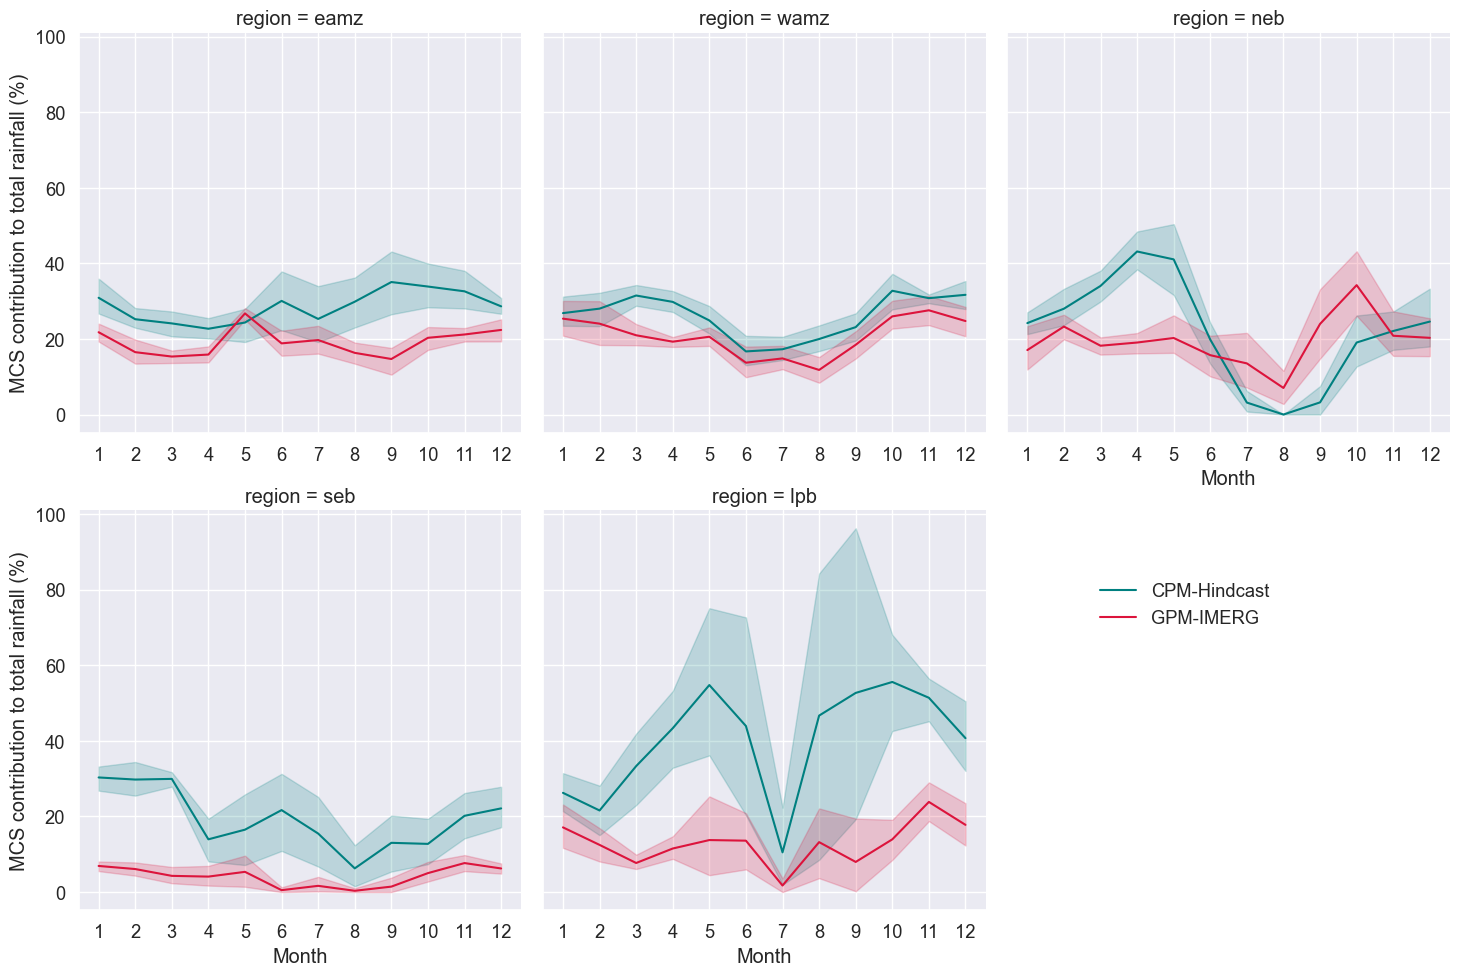

In [71]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.relplot(
    data=combined, x="month", y="mcs_contribution", hue='type',
    col="region",
    kind="line", col_wrap=3, palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], facet_kws=dict(sharex=False)
)

g.set_axis_labels("Month", "MCS contribution to total rainfall (%)")
g.legend.set_title(" ")
g.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45))
g.set(xticks=np.arange(1,13,1))
g.set_xticklabels(labels=np.arange(1,13), step=1)

Text(-8, 120, 'Mean monthly MCS contribution to total rainfall per region per month')

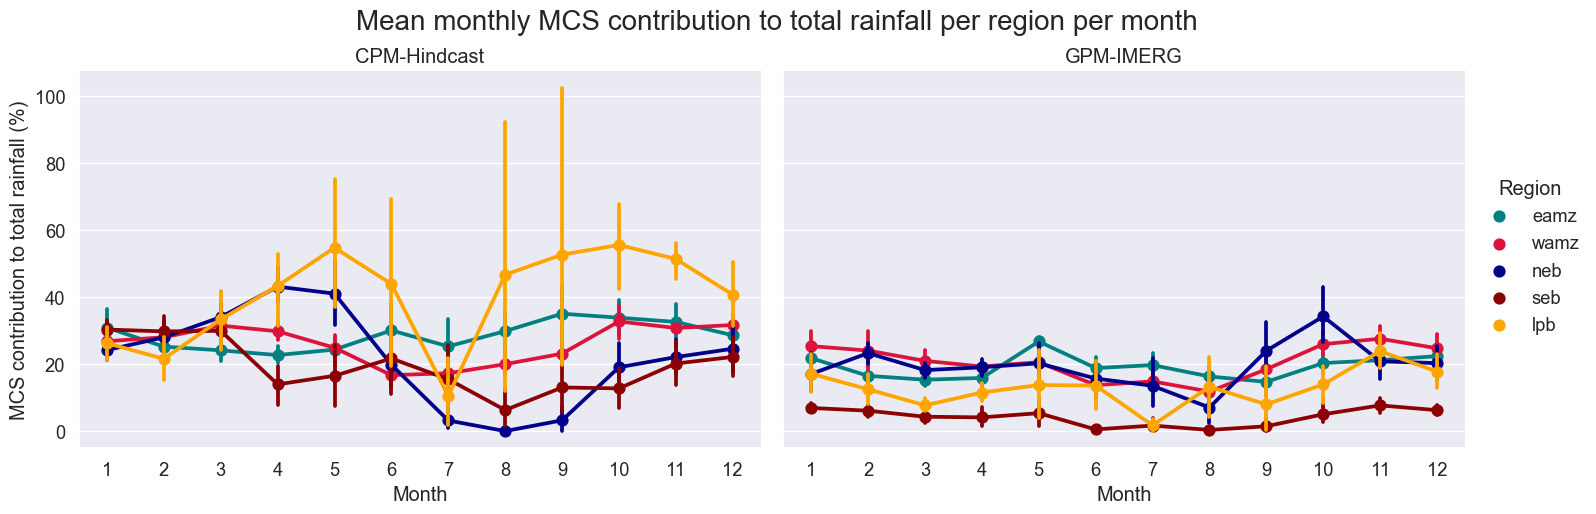

In [79]:

sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.catplot(x="month", y="mcs_contribution", hue="region", data=combined, col='type',
    palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], kind='point', aspect=1.5, facet_kws=dict(sharex=False)
)
g.set_axis_labels("Month", "MCS contribution to total rainfall (%)")
g.legend.set_title("Region")
g.set_titles("{col_name}")
#plt.ylim(0,700000)
plt.text(-8,120,'Mean monthly MCS contribution to total rainfall per region per month', fontsize=20)

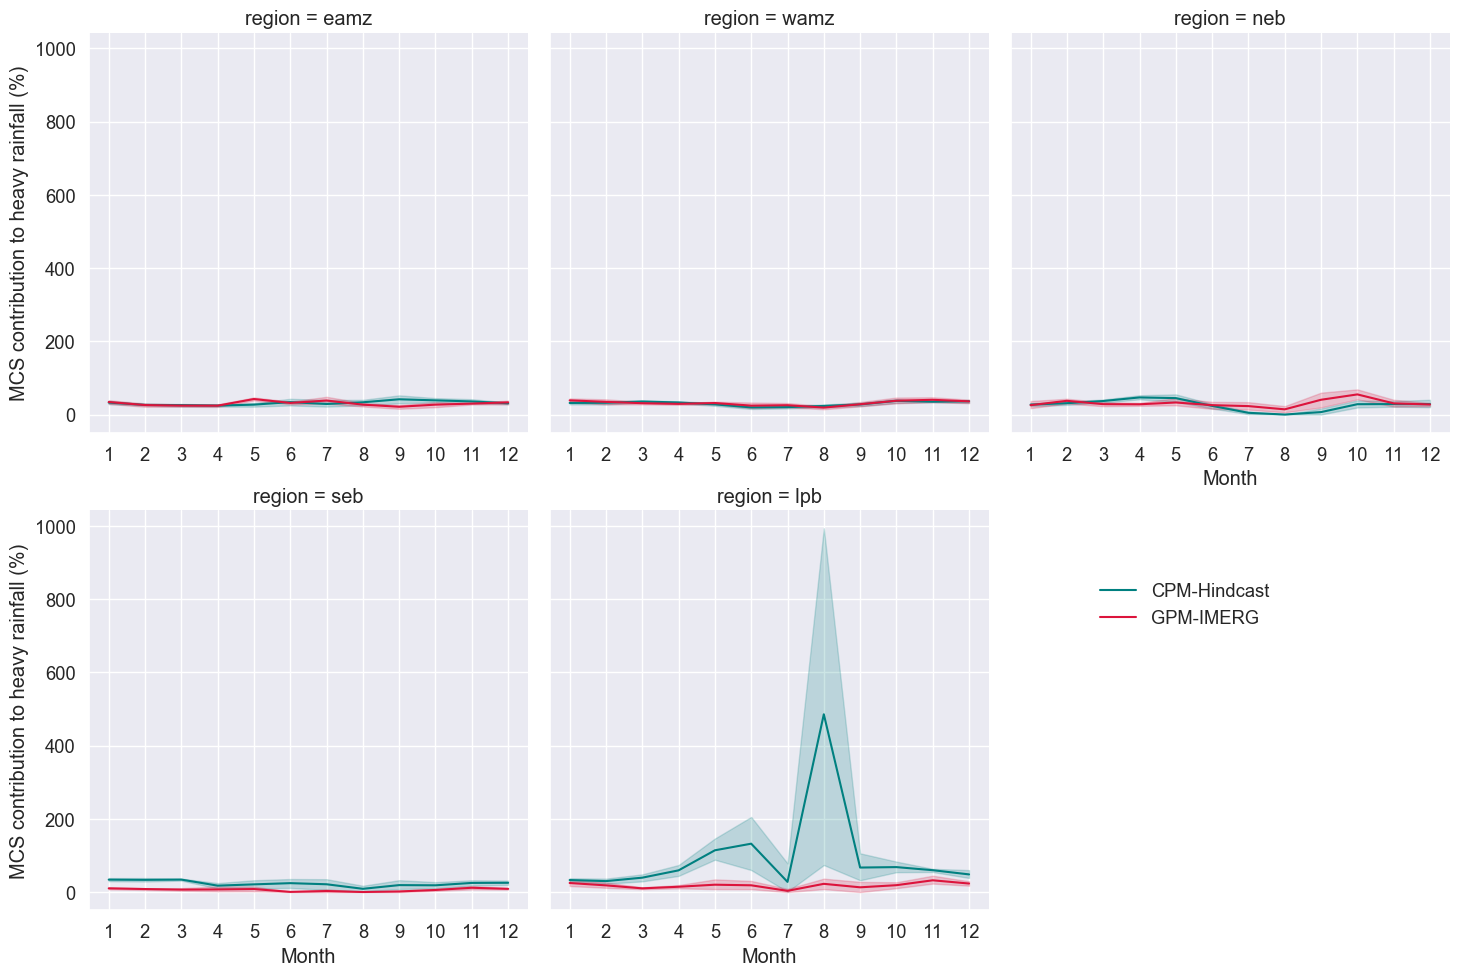

In [87]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.relplot(
    data=combined, x="month", y="mcs_heavy_contribution", hue='type',
    col="region",
    kind="line", col_wrap=3, palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], facet_kws=dict(sharex=False)
)

g.set_axis_labels("Month", "MCS contribution to heavy rainfall (%)")
g.legend.set_title(" ")
g.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45))
g.set(xticks=np.arange(1,13,1))
g.set_xticklabels(labels=np.arange(1,13), step=1)

Text(-8, 120, 'Mean monthly MCS contribution to heavy rainfall per region per month')

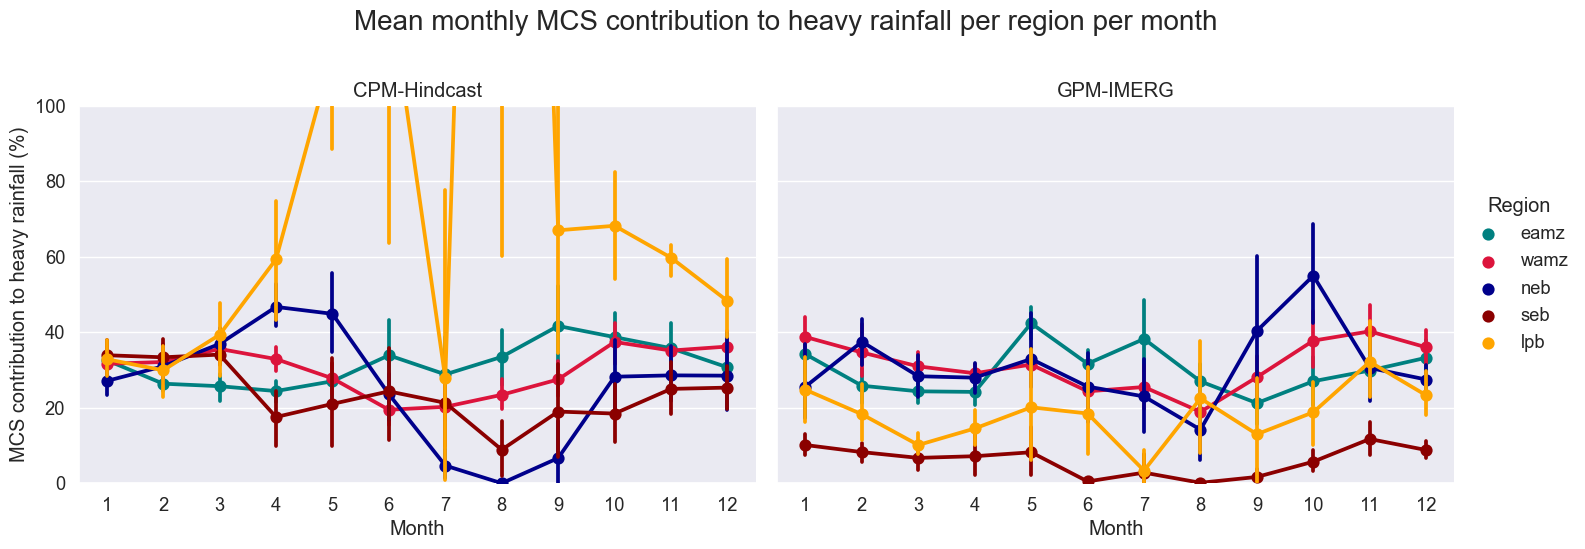

In [89]:

sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

g = sns.catplot(x="month", y="mcs_heavy_contribution", hue="region", data=combined, col='type',
    palette=['teal', 'crimson', 'darkblue', 'darkred', 'orange'], kind='point', aspect=1.5, facet_kws=dict(sharex=False)
)
g.set_axis_labels("Month", "MCS contribution to heavy rainfall (%)")
g.legend.set_title("Region")
g.set_titles("{col_name}")
plt.ylim(0,100)
plt.text(-8,120,'Mean monthly MCS contribution to heavy rainfall per region per month', fontsize=20)